# DIP_Mechanics
# Mathematical modeling <a class="anchor" id="mathematicalModel"></a>

Cartesian coordinates of the $leg_1$ and pole_{2} will be 
\begin{equation}
\begin{bmatrix}
q_1 \\ q_2 
\end{bmatrix}
\qquad \text{and} \qquad 
\begin{bmatrix}
q_1 + l \sin(q_2) \\ l \cos(q_2)] 
\end{bmatrix}
\end{equation}
where ($q_1$) is the horizontal position of the cart and ($q_2$) is the angle of the pendulum.

The state, $x$ and state derivative, $\dot{x}$ will give the dynamics of the system in first-order form and represnets the minimal generalized coordinates and its derivatives
\begin{equation}
 x =
 \begin{bmatrix}
  q_1 \\ q_2 \\ \dot{q_1} \\ \dot{q_2}
\end{bmatrix}	
\qquad \text{and} \qquad 		
\dot{x} = f ( x , u ) =
\begin{bmatrix}
\dot{q_1} \\ \dot{q_2} \\ \ddot{q_1} \\ \ddot{q_2}
\end{bmatrix}
\end{equation}

Using Lagrangian method, 	
$ L = T - V $
where T is the kinetic energy and V the potential energy of the system. L summarizes the system dynamics.

\begin{align}
& T = T_{cart} + T_{pole} \\
&T_{cart} = \frac{1}{2} m_1\dot{ q_1}^2 \\
&T_{pole} = \frac{1}{2} m_2  [\dot{(q_1 + l \sin(q_2)}^2 +\dot{(l\cos(q_2)}^2] \\\\
& V = V_{cart} + V_{pole} \\
&V = 0 + m_2 g l \cos(q_2) \\
\end{align}

The potential energy of the cart is zero since it is not moving vertically and it has a height of 0.

Thus $L = \frac{1}{2} m_1 q_1^2 + \frac{1}{2} m_2 [\dot{(x + l \sin(q_2)}^2 +\dot{(l\cos(q_2)}^2] - m_2 g l \cos(q_2)$


The generalized coordinates could be defined as 
\begin{equation}	
X = 
\begin{bmatrix}
q_1  \\ q_2 
\end{bmatrix}
\end{equation}
To yield the equations of motion for the cart/pendulum system, the Lagrangian equations will: 
\begin{align}
&\frac{d}{dt}(\frac{\partial L}{\partial{\dot{q_1}}}) - \frac{\partial L}{\partial{\dot{q_1}}} = u \\
&\frac{d}{dt}(\frac{\partial L}{\partial{\dot{q_2}}}) - \frac{\partial L}{\partial{\dot{q_2}}} = 0
\end{align}

Solving for the partial and time derivatives will yield
\begin{align}
&(m_1 + m_2) \ddot{q_1} + m_1 l \ddot{q_2} \cos(q_2) - m_2 l \dot{q_2}^2 \sin(q_2) = u \\
&m_2 l \ddot{q_1} \cos(q_2) + m_2 l^2 \ddot{q_2}  - m_2 g l \sin(q_2) = 0 
\end{align}
The detailed derivations of the derivatives can be found on this <a href=\"http://www.aoengr.com/Dynamics/PendulumOnCart.pdf\">webisite.</a> 

Rearranging the above equations and solving for the $\ddot{q_1}$ and $\ddot{q_2} $ terms respectively,
\begin{align}
&\ddot{q_1} = \frac{ l m_2 \sin(q_2) \dot{q_2}^2 + u + m_{2} g \cos(q_{2}) sin(q_2)} {m_1 + m_2\sin^2(q_2)} \\
&\ddot{q_2} = \frac{ l m_2 \cos(q_2) \sin(q_2^2) \dot{q_2}^2 + u \cos(q_2) + (m_1 + m_2) g \sin(q_2)} {l (m_1 + m_2\sin^2(q_2))}
\end{align}


In [95]:
using JuMP, Ipopt

function DIP(z,Time)
    
    m = Model(solver = IpoptSolver(print_level=0))
    K = length(Time) #number of collocation points
    dT = Time[K]/K
    # assign joint displacements / velocities from state variables
    @variable(m, q[1:4,1:K])
    @variable(m, D[1:2,1:2,1:K])
    @variable(m, G[1:2,1:K])
    @variable(m, V[1:2,1:K])
    @variable(m, B[1:2,1:K])
#     @variable(m, dummy[1:4])
#     @constraint(m, q[1:4,1] .== z)
#     @constraint(m, q[1:4,K] .== z)
    @constraint(m, q[1:2,1] .== z[1:2])
    @constraint(m, q[1:2,K] .== z[1:2])
    #input torque
    @variable(m, T[1:2,1:K])
    @variable(m, k[1:4,1:K])
#         setcategory(T,:Float64)
    #     @constraint(m, T[1,1]==0)
    #     @constraint(m, T[2,1]==0)

    #form joint acceleration vector 
    @variable(m, qd[1:4,1:K])
    
    # model parameters
    g = 9.81
    m1 = 1
    m2 = 1
    L1 = 10
    L2 = 10
    Lc1 = L1/2
    Lc2 = L2/2
    I1 = (1/12)*m1*L1^2
    I2 = (1/12)*m2*L2^2;
    
    for k in 1:K
        # precalculate sin and cos terms
        @NLexpression(m, s, sin(q[1,k]))
        @NLexpression(m, c1, cos(q[1,k]))
        @NLexpression(m, s2, sin(q[2,k]))
        @NLexpression(m, c2, cos(q[2,k]))
        @NLexpression(m, s12, sin(q[1,k]+q[2,k]))
        @NLexpression(m, c12, cos(q[1,k]+q[2,k]))


        # mass matrix calculation
        @NLconstraint(m, D[1,1,k] == m1*Lc1^2 + m2*(L1^2 + Lc2^2 + 2*L1*Lc2*c2) + I1 + I2)
        @NLconstraint(m, D[1,2,k] == m2*(Lc2^2+ L1*Lc2*c2) + I2)
    #     @NLexpression(m, d21, d12)
         @NLconstraint(m, D[2,1,k] == m2*(Lc2^2+ L1*Lc2*c2) + I2)
        @NLconstraint(m, D[2,2,k] == m2*Lc2^2 + I2)

        #coriolis and centrifugal terms
        @NLexpression(m, h, -m2*L1*Lc2*s2)
        @NLexpression(m, c111, 0)
        @NLexpression(m, c121, h)
        @NLexpression(m, c211, h)
        @NLexpression(m, c221, h)
        @NLexpression(m, c112, -h)
        @NLexpression(m, c122, 0)
        @NLexpression(m, c222, 0)
        @NLconstraint(m, V[1,k] == c121*q[3,k]*q[4,k] + c211*q[4,k]*q[3,k] + c221*q[4,k]^2)
        @NLconstraint(m, V[2,k] == c112*q[3,k]^2)

        # gravity vector
        @NLexpression(m, g1, (m1*Lc1 + m2*L1)*g*c1 + m2*Lc2*g*c12)
        @NLexpression(m, g2, m2*Lc2*g*c12)
        @NLconstraint(m, G[1,k] == g1)
        @NLconstraint(m, G[2,k] == g2)

        #joint viscous damping (added to bring manipulator to rest)
        b = 0.0
        @NLexpression(m, B[1,k] == b*q[3,k])
        @NLexpression(m, B[2,k] == b*q[4,k])

        
        @NLconstraint(m, D[1,1,k]*qd[1,k] + D[1,2,k]*qd[2,k] + V[1,k] + G[1,k] + B[1,k] == T[1,k] )
        @NLconstraint(m, D[2,1,k]*qd[1,k] + D[2,2,k]*qd[2,k] + V[2,k] + G[2,k] + B[2,k] == T[2,k])
#         @NLconstraint(m, D[1:2,1,k]*qd[1,k] + D[1:2,2,k]*qd[2,k] + V[1:2,k] + G[1:2,k] + B[1:2,k] == T[1:2,k]) 
        # non-linear combination error when trying to use full matrix form
    end

# Runge-Kutta integration
    
#     for i = 1:K-1
#         @NLconstraint(m, k[1,i] == qd[:,i])
#         @NLconstraint(m, k[2,i] == qd[:,i] + 0.5*k1*dT)
#         @NLconstraint(m, k[3,i] == qd[:,i] + 0.5*k2*dT)
#         @NLconstraint(m, k[4,i] == qd[:,i] + k3*dT)
#         @NLconstraint(m, qd[:,i+1] == qd[:,i] + (1/6)*(k1 + 2*k2 + 2*k3 + k4)*dT ) 
#     end
    
#add forward euler dynamics constraint
#     for k in 1:K-1
#         @constraint(m, q[:,k+1] .== q[:,k] + dT*qd[:,k])
#     end

#add backwards euler dynamics constraint
    for k in 1:K-1
        @constraint(m, q[:,k+1] .== q[:,k] + .5*dT*(qd[:,k] + qd[:,k+1]))
        @constraint(m, q[3:4,k] .== qd[1:2,k]) 
    end 
    
    
# hard state constraints
    for k in 1:K
        @constraint(m, z[1:2] - 0.2 .<= q[1:2,k] .<= z[1:2] + 0.2)
#         @constraint(m, q[1:2,k] .== z[1:2])# can not currently solve this constraint
    end 
    
# min Torque
    @objective(m, Min, sum(T[1,:].^2 + T[2,:].^2))
# @objective(m, Min, sum(T[2,:].^2))
#     @objective(m, Min, sum(q+dummy))
    
# min change of torque
#     for k in 1:K-1
#         @objective(m, Min, sum((T[1,k]-T[1,k+1]).^2 + (T[2,k]-T[2,k+1]).^2))
#     end
    

# solve for optimization
    status = solve(m)
    state = getvalue(q)
    torque =  getvalue(T)
    print(status, "\n")
# print(state)
    
# assign state variable derivatives
#     zDot[1,:] = getvalue(q[3])
#     zDot[2,:] = getvalue(q[4])
#     zDot[3,:] = getvalue(qd[1])
#     zDot[4,:] = getvalue(qd[2])
    return (state, torque)
end


DIP (generic function with 1 method)

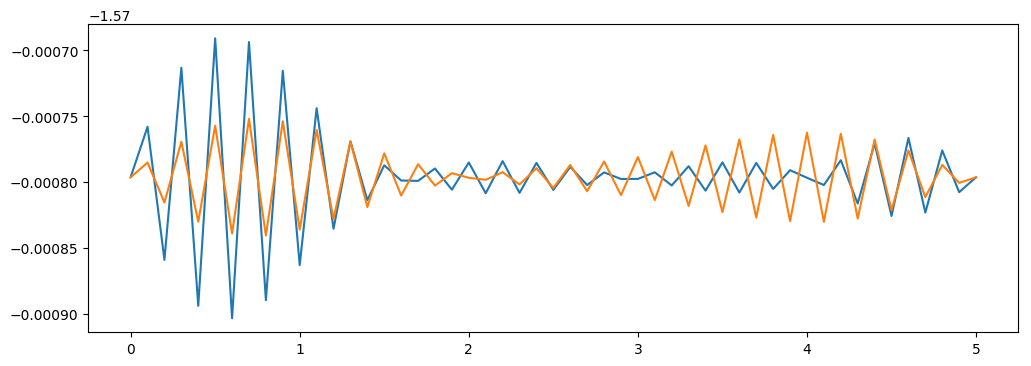

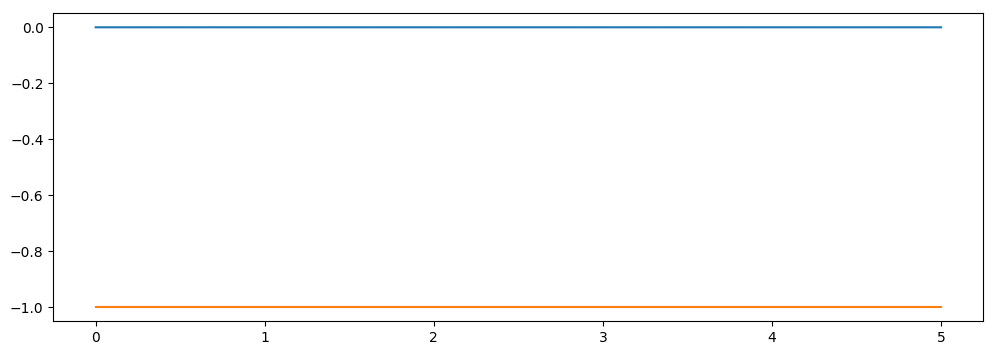

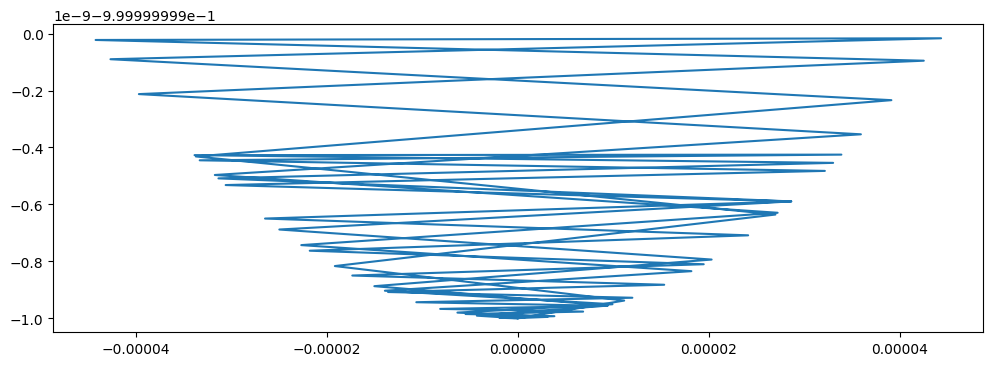

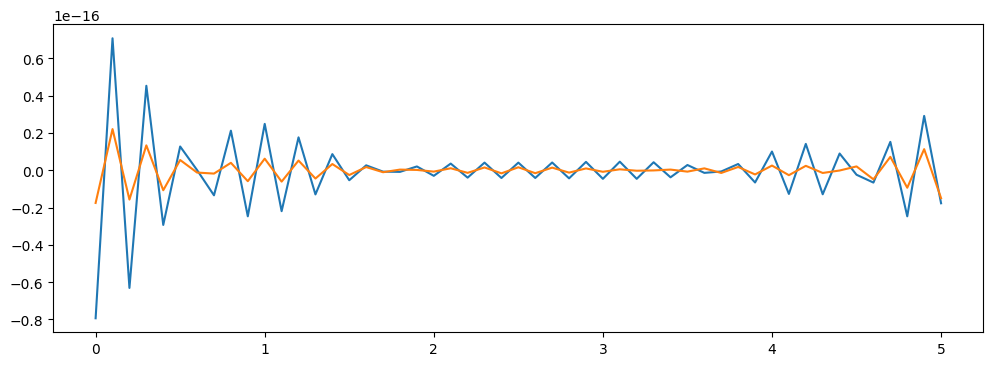

Optimal


2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000004922C080>
 PyObject <matplotlib.lines.Line2D object at 0x0000000049228CC0>

In [96]:
using PyPlot
h = 0.1
tf = 5
Time = 0:h:tf                   #time vector
z = [-pi/2; -pi/2; 0; 0] #initial position and velocity
# z = [0; 0; 0; 0] #initial position and velocity
state,torque = DIP(z,Time)

figure(figsize=(12,4)) 
plot(Time,state[1,:],Time,state[2,:])
# plot(Time,state[1,:],Time,state[2,:],Time,state[3,:],Time,state[4,:])

figure(figsize=(12,4)) 
plot(Time,cos.(state[2,:]),Time,sin.(state[2,:]))

figure(figsize=(12,4)) 
plot(cos.(state[2,:]),sin.(state[2,:]))

figure(figsize=(12,4)) 
plot(Time,torque[1,:],Time,torque[2,:])